# The Simpsons
![The Simpsons](https://upload.wikimedia.org/wikipedia/ru/4/42/Simpsons_cast.jpg)

...one more pipeline...

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as tfs
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models


# Load data

In [2]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     print('{} CONTAINS {} files'.format(dirname, len(filenames)))

In [3]:
input_dir = '/kaggle/input/journey-springfield/train/simpsons_dataset/'
rescale_size = 244
batch_size = 32 # 32 - resnet152. 64 - all another
# Imagenet mean and standard (are calculated from all of images)
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [49]:
transform = tfs.Compose([
    tfs.Resize((int(rescale_size * 1.25), int(rescale_size * 1.25))),
    tfs.RandomCrop(rescale_size),
    tfs.RandomHorizontalFlip(),
    tfs.ToTensor(),
    tfs.Normalize(imagenet_mean, imagenet_std)
])

dataset_full = torchvision.datasets.ImageFolder(root=input_dir, transform=transform)

# split full dataset
train_idx, valid_idx = train_test_split(list(range(len(dataset_full))), train_size=0.8)


In [50]:
dataset = {
    'train': torch.utils.data.Subset(dataset_full, train_idx),
    'valid': torch.utils.data.Subset(dataset_full, valid_idx)
}

dataset_size = {ds: len(dataset[ds]) for ds in ['train', 'valid']}
dataset_classes = np.array(dataset_full.classes)
print('classes:', dataset_classes, '\nsize', dataset_size)

dataloader = {
    'train': torch.utils.data.DataLoader(
        dataset=dataset['train'], batch_size=batch_size, shuffle=True, num_workers=2
    ),
    'valid': torch.utils.data.DataLoader(
        dataset=dataset['valid'], batch_size=batch_size, shuffle=False, num_workers=2
    ),
}

classes: ['abraham_grampa_simpson' 'agnes_skinner' 'apu_nahasapeemapetilon'
 'barney_gumble' 'bart_simpson' 'carl_carlson' 'charles_montgomery_burns'
 'chief_wiggum' 'cletus_spuckler' 'comic_book_guy' 'disco_stu'
 'edna_krabappel' 'fat_tony' 'gil' 'groundskeeper_willie' 'homer_simpson'
 'kent_brockman' 'krusty_the_clown' 'lenny_leonard' 'lionel_hutz'
 'lisa_simpson' 'maggie_simpson' 'marge_simpson' 'martin_prince'
 'mayor_quimby' 'milhouse_van_houten' 'miss_hoover' 'moe_szyslak'
 'ned_flanders' 'nelson_muntz' 'otto_mann' 'patty_bouvier'
 'principal_skinner' 'professor_john_frink' 'rainier_wolfcastle'
 'ralph_wiggum' 'selma_bouvier' 'sideshow_bob' 'sideshow_mel'
 'snake_jailbird' 'troy_mcclure' 'waylon_smithers'] 
size {'train': 16746, 'valid': 4187}


In [51]:
transform = tfs.Compose([
    tfs.Resize((int(rescale_size * 1.05), int(rescale_size * 1.05))),
    tfs.CenterCrop(rescale_size),
    tfs.ToTensor(),
    tfs.Normalize(imagenet_mean, imagenet_std)
])
dataset_test = torchvision.datasets.ImageFolder(
    root='/kaggle/input/journey-springfield/testset',
    transform=transform
)
dataloader_test = torch.utils.data.DataLoader(dataset_test, shuffle=False, batch_size=batch_size)
test_filenames = [fn[0].split('/')[-1] for fn in dataset_test.imgs]

# Show some data

In [6]:
def get_batches(dataloader, num_of_batches=1):
    assert(num_of_batches > 0)
    images, classes = next(iter(dataloader))
    for _ in range(num_of_batches - 1):
        image_batch, cls_batch = next(iter(dataloader))
        images = torch.cat([images, image_batch], dim=0)
        classes = torch.cat([classes, cls_batch], dim=0)
    return images, classes

In [7]:
def show_batches(images, classes):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    cols = (images.shape[0] + 3) // 4
    images = images.numpy().transpose(0,2,3,1)
    images = images * imagenet_std + imagenet_mean
    fig, axes = plt.subplots(cols, 4, figsize=(12, cols * 3))
    for ax, img, img_cls in zip(axes.flatten(), images, classes.numpy()):
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_xlabel(dataset_classes[img_cls], fontsize=16)
    plt.tight_layout()
    plt.show()

In [8]:
# images, classes = get_batches(dataloader['train'])
# show_batches(images, classes)

# Fit functions

In [9]:
def train_model(
    model: torch.nn.Module,
    criterion: torch.nn.Module,
    optimizer: torch.nn.Module,
    sheduler: torch.nn.Module,
    epochs: int = 10
) -> (torch.nn.Module, dict):
    r"""Training the model. Returns best model, dictionary of train and validation losses, dictionary of train and validation accuracies.
    Args:
        model (torch.nn.Module): Neural network
        criterion (torch.nn.Module): Cost function
        optimizer (torch.nn.Module): Optimization algorithm
        sheduler (torch.nn.Module): Learning rate change policy
        epochs (int): Number of training iterations. Default: 25
    """
    
    losses = {'train': [], 'valid': []}
    accuracies = {'train': [], 'valid': []}
    best_model_weights = model.state_dict()
    best_accuracy = 0.
    progress = tqdm(range(epochs), desc='Epoch:')
    
    for epoch in progress:
        for phase in ['train', 'valid']:
            loss_accum = 0.
            corr_accum = 0
            model.train(mode=(phase == 'train'))
            
            for inputs, labels in tqdm(dataloader[phase], desc=f'Phase {phase}:'):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
            
                if phase == 'train':
                    optimizer.zero_grad()
                    outp = model(inputs)
                    loss = criterion(outp, labels)
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outp = model(inputs)
                        loss = criterion(outp, labels)
                
                preds = torch.argmax(outp, -1)
                loss_accum += loss.item()
                corr_accum += (preds == labels.data).sum()

            if phase == 'train':
                sheduler.step()
                
            epoch_loss = loss_accum / dataset_size[phase]
            epoch_accuracy = corr_accum / dataset_size[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_accuracy)
            progress.set_description('loss: {:.4f}, acc: {:.4f}'.format(epoch_loss, epoch_accuracy))
            if phase == 'valid' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_weights = model.state_dict()
    
    model.load_state_dict(best_model_weights)
    return model, losses, accuracies

In [10]:
def show_metrics(metrics):
    plt.figure(figsize=(12, 8))
    plt.plot(metrics['train'], label='train')
    plt.plot(metrics['valid'], label='val')
    plt.grid()
    plt.legend()
    plt.show()

In [11]:
def show_metrics_all(losses, accuracies):
    def show_ax(ax_idx, metric, title):
        axes[ax_idx].plot(metric['train'], label='train')
        axes[ax_idx].plot(metric['valid'], label='valid')
        axes[ax_idx].grid()
        axes[ax_idx].legend()
        axes[ax_idx].set_title(title)

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    show_ax(0, losses, 'loss')
    show_ax(1, accuracies, 'accuracy')
    plt.show()

# Predict functions

In [12]:
def predict(model, dataloader_test):
    logits = []
    model.eval()
    with torch.no_grad():
        for inputs, _ in tqdm(dataloader_test):
            inputs = inputs.to(DEVICE)
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [13]:
def predict_to_submission(model, dataloader_test=dataloader_test, test_filenames=test_filenames, dataset_classes=dataset_classes):
    probs = predict(model, dataloader_test)
    print(probs.shape)
    predictions = np.argmax(probs, axis=1)
    preds = dataset_classes[predictions]
    submission = pd.read_csv('/kaggle/input/journey-springfield/sample_submission.csv')
    submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds}).sort_values('Id')
    submission.to_csv('./submission.csv', index=False)

# Resnet Model

In [54]:
model = torchvision.models.resnet152(pretrained=True)

In [55]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 2048
# Заменяем Fully-Connected слой на наш линейный классификатор
model.fc = nn.Linear(num_features, 42)

In [ ]:
model

Epoch::   0%|          | 0/1 [00:00<?, ?it/s]

Phase train::   0%|          | 0/524 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/131 [00:00<?, ?it/s]

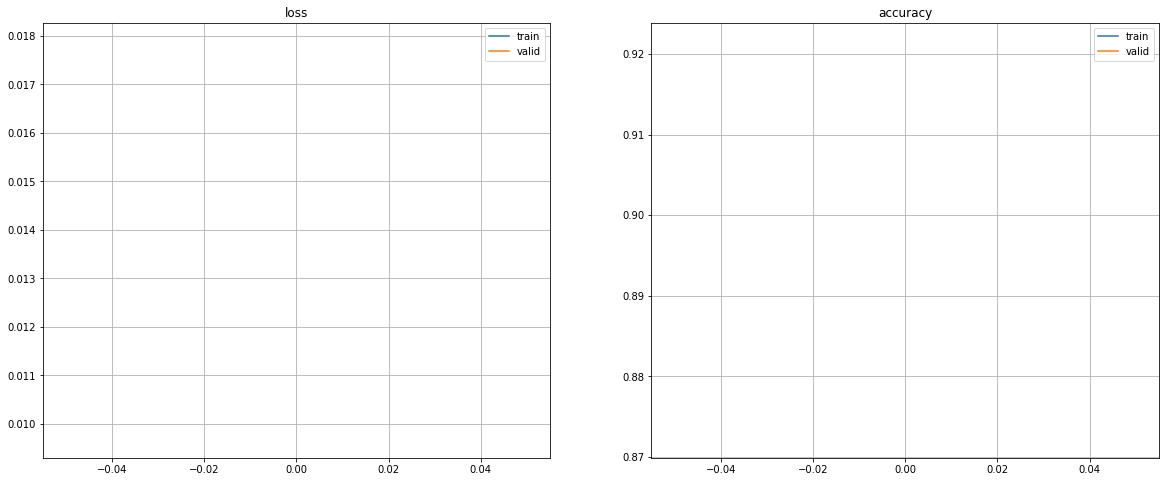

  0%|          | 0/31 [00:00<?, ?it/s]

(991, 42)


In [58]:
model.to(DEVICE)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model, losses, accuracies = train_model(model, loss, optimizer, sheduler, epochs=1)
show_metrics_all(losses, accuracies)
predict_to_submission(model)

In [60]:
probs = predict(model, dataloader_test)
print(probs.shape)
predictions = np.argmax(probs, axis=1)
preds = dataset_classes[predictions]
submission = pd.read_csv('/kaggle/input/journey-springfield/sample_submission.csv')
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds}).sort_values('Id')
submission.to_csv('./submission.csv', index=False)

  0%|          | 0/31 [00:00<?, ?it/s]

(991, 42)


# AlexNet

In [ ]:
# model_alexnet = torchvision.models.alexnet(pretrained=True)

In [ ]:
# for param in model_alexnet.features.parameters():
#     param.requires_grad = False
# num_in_features = 4096
# num_out_features = len(dataset_full.classes)
# model_alexnet.classifier[6] = nn.Linear(in_features=num_in_features, out_features=num_out_features, bias=True)
# # for param in model_alexnet.parameters():
# #     print(param.requires_grad)
# model_alexnet

In [ ]:
# model_alexnet.to(DEVICE)
# loss = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(model_alexnet.parameters(), lr=1e-3)
# sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# model_alexnet, losses, accuracies = train_model(model_alexnet, loss, optimizer, sheduler)

In [ ]:
# show_metrics_all(losses, accuracies)

In [ ]:
# predict_to_submission(model_alexnet)